In [ ]:
%load_ext autoreload

In [ ]:
"Figure 13."

In [2]:
import numpy as np
import pickle
from scipy.signal import butter, filtfilt

from basicOperations.manifoldOperations import matrixDistance, frechetMean, tangentMap

In [3]:
from matplotlib import font_manager
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fontPath = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf'
fontProp = font_manager.FontProperties(fname = fontPath)

font_manager.fontManager.addfont(fontPath)
mpl.rcParams['font.family'] = fontProp.get_name()

In [4]:
numberChannels = 12
numberGestures = 10
trialsPerGesture = 36
numberSubjects = 91

In [5]:
collateData = []
Frequency = []

for subjectNumber in range(1, 100):
    if subjectNumber not in [5, 11, 14, 17, 18, 35, 38, 41]:
        name = "../formattedData/" + str(subjectNumber) + ".pkl"
        with open(name, "rb") as file:
            loadedData = pickle.load(file)

        Features = loadedData["EMG"]
        normalizedFeatures = Features
        Labels = loadedData["Labels"]
        samples = 2 * loadedData["Frequency"]

        Indices =  {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
        for i in range(len(Labels)):
            Indices[Labels[i]].append(i)

        gesturesLabels = np.zeros((numberGestures, trialsPerGesture, numberChannels, 4000))
        for i in range(numberGestures):
            for j in range(trialsPerGesture):
                gesturesLabels[i, j] = normalizedFeatures[Indices[i][j], :, :4000]
        
        collateData.append(gesturesLabels)
        Frequency.append(loadedData["Frequency"])

In [6]:
collateData = np.array(collateData)
Frequency = np.array(Frequency)

print(collateData.shape)
print(Frequency.shape)

(91, 10, 36, 12, 4000)
(91,)


In [7]:
def butterworthBandpass(lowcut, highcut, fs, order = 3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype = 'band')
    return b, a

def applyBandpassFilter(data, lowcut, highcut, fs, order = 3):
    b, a = butterworthBandpass(lowcut, highcut, fs, order = order)
    filteredData = filtfilt(b, a, data, axis = -1)
    return filteredData

In [8]:
frequencies = np.array([[20, 50], [50, 110], [110, 230], [230, 450]])
print(frequencies)

[[ 20  50]
 [ 50 110]
 [110 230]
 [230 450]]


In [9]:
frequencies = np.array([[20, 50], [50, 110], [110, 230], [230, 450], [20, 450]])
filteredData = np.zeros((5, numberSubjects, numberGestures, trialsPerGesture, numberChannels, 4000))
for i in range(len(frequencies)):
    print(i)
    for subject in range(numberSubjects):
        filteredData[i, subject] = applyBandpassFilter(collateData[subject], frequencies[i, 0], frequencies[i, 1], Frequency[subject]) 

0
1
2
3
4


In [10]:
print(filteredData.shape)

(5, 91, 10, 36, 12, 4000)


In [11]:
normalizedFilteredData = np.zeros((5, numberSubjects, numberGestures, trialsPerGesture, numberChannels, 4000))
for i in range(len(frequencies)):
    for j in range(numberSubjects):
        mean = np.mean(filteredData[i, j], axis = -1)
        std = np.std(filteredData[i, j], axis = -1)
        normalizedFilteredData[i, j] = (filteredData[i, j] - mean[..., np.newaxis])/std[..., np.newaxis]

In [12]:
print(normalizedFilteredData.shape)

(5, 91, 10, 36, 12, 4000)


In [13]:
covarianceMatrices = np.zeros((5, numberSubjects, 9, numberGestures, trialsPerGesture, numberChannels, numberChannels))

In [14]:
timeSegments = [800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]

In [15]:
for frequency in range(5):
    for subject in range(numberSubjects):
        for timeSegment in range(9):
            for gesture in range(numberGestures):
                for repeat in range(trialsPerGesture):
                        dataTemp = normalizedFilteredData[frequency, subject, gesture, repeat, :, :timeSegments[timeSegment]]
                        dataTemp1 = 1/(timeSegments[timeSegment]) * (dataTemp @ dataTemp.T)
                        covarianceMatrices[frequency, subject, timeSegment, gesture, repeat] = 0.9 * dataTemp1 + 0.1/12 * dataTemp1 * np.eye(12, 12)

In [16]:
geodesicDistance = matrixDistance()
manifoldMean = frechetMean()
logMap = tangentMap()

In [17]:
trainCentroid = np.zeros((5, numberSubjects, 9, numberGestures, numberChannels, numberChannels))

for band in range(5):
    for subject in range(numberSubjects):
        for timeSegment in range(9):
            for gesture in range(numberGestures):
                    trainCentroid[band, subject, timeSegment, gesture, :, :] = manifoldMean.mean(covarianceMatrices[band, subject, timeSegment, gesture, :18,  :, :])

testFeatures = np.zeros((5, numberSubjects, 9, 180, numberChannels, numberChannels))
testLabels = np.zeros((5, numberSubjects, 9, 180))

for band in range(5):
    for subject in range(numberSubjects):
        for timeSegment in range(9):
            count = 0
            for gesture in range(numberGestures):
                testFeatures[band, subject, timeSegment, count:count + 18] = covarianceMatrices[band, subject, timeSegment, gesture, 18:, :, :]
                testLabels[band, subject, timeSegment, count:count + 18] = [gesture] * 18
                count += 18

predictLabels = np.zeros((5, numberSubjects, 9, 180))

for band in range(5):
    print(band)
    for subject in range(numberSubjects):
        for timeSegemnt in range(9):
            for k in range(180):
                distances = np.zeros((numberGestures))
                for m in range(numberGestures):
                    distances[m] = geodesicDistance.distance(testFeatures[band, subject, timeSegemnt, k], trainCentroid[band, subject, timeSegemnt, m])
                predictLabels[band, subject, timeSegemnt, k] = np.argmin(distances)

corrects = np.zeros((5, numberSubjects, 9))

for band in range(5):
    for subject in range(numberSubjects):
        for timeSegment in range(9):
            correct = np.mean((predictLabels[band, subject, timeSegment] == testLabels[band, subject, timeSegment]))
            corrects[band, subject, timeSegment] = correct

0
1
2
3
4


In [18]:
meanCorrects = np.mean(corrects, axis = 1)
print(meanCorrects.shape)

(5, 9)


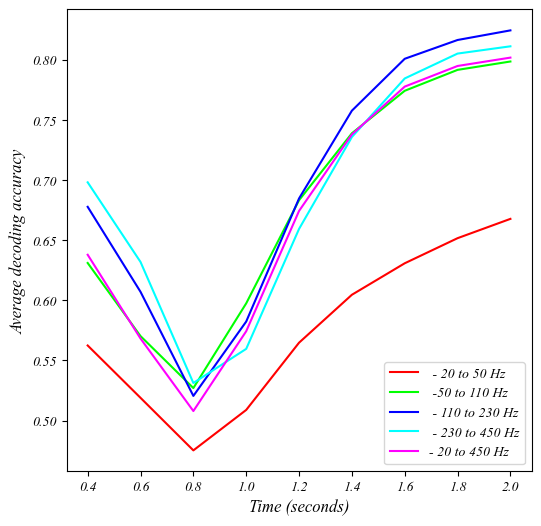

In [19]:
colors = ['#FF0000', '#00FF00', '#0000FF', '#00FFFF', '#FF00FF', '#FFA500', '#800080', '#A52A2A', '#FFC0CB']

tags = [" - 20 to 50 Hz", " -50 to 110 Hz", " - 110 to 230 Hz", " - 230 to 450 Hz", "- 20 to 450 Hz"]
plt.figure(figsize = (6, 6))
for i in range(5):
    plt.plot(np.array([800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000])/2000, meanCorrects[i], label = tags[i], color = colors[i])


plt.xlabel('Time (seconds)', fontproperties = fontProp, fontsize = 12)
plt.ylabel('Average decoding accuracy', fontproperties = fontProp, fontsize = 12)
plt.legend(loc = 'lower right')
"""plt.savefig("decodingAccuracyTimepoints.eps", format = "eps", bbox_inches = 'tight')"""
plt.show()
plt.close()